In [1]:
from drosoph_vae.settings.config import SetupConfig
# adapt according to your machine (0 should be fine, if you have a GPU)
if SetupConfig.runs_on_lab_server():
    %env CUDA_DEVICE_ORDER=PCI_BUS_ID
    %env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


# VAE using the reparametrization trick

## Imports and enabling of eager execution

In [2]:
import json
from collections import namedtuple
from functools import partial
import itertools
from functional import seq
from functools import reduce
import warnings
import os
import traceback
import time
import glob
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import PIL
import imageio
from IPython import display
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from hdbscan import HDBSCAN

from importlib import reload # for debugging and developing, optional

import tensorflow as tf
import tensorflow.contrib as tfc
import tensorflow.contrib.eager as tfe
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_probability as tfp

# for the KL-loss explosion problem
tf.enable_eager_execution()
# we currently handle them ourselves. but with this, it will throw an error before we can apply the fix
tfe.seterr(inf_or_nan='raise')

# otherwise TF will print soooo many warnings
warnings.filterwarnings('ignore', '.*FutureWarning.*np.complexfloating.*')

from drosoph_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_
import drosoph_vae.helpers.tensorflow as tf_helpers
sess = tf.InteractiveSession(config=_TF_DEFAULT_SESSION_CONFIG_)
tf.keras.backend.set_session(sess)

from drosoph_vae import data_loading
from drosoph_vae import settings
from drosoph_vae import preprocessing
from drosoph_vae.helpers import video, plots, misc, jupyter
from drosoph_vae.helpers.misc import extract_args, chunks, foldl, if_last
from drosoph_vae.helpers.jupyter import display_video
from drosoph_vae.helpers.logging import enable_logging
from drosoph_vae.helpers.tensorflow import to_tf_data
from drosoph_vae.settings import config, skeleton
from drosoph_vae.settings import data as SD
from drosoph_vae.settings.config import RunConfig, SetupConfig
from drosoph_vae.training import vae as vae_training
from drosoph_vae.training import supervised as supervised_training
from drosoph_vae.losses.normalized_mutual_information import normalized_mutual_information
from drosoph_vae.losses.purity import purity
from drosoph_vae.models.drosoph_vae_conv import DrosophVAEConv
from drosoph_vae.models.drosoph_vae_skip_conv import DrosophVAESkipConv

In [3]:
jupyter.fix_layout()
enable_logging()

# Setup, loading of data

In [4]:
setup_cfg = SetupConfig()
run_cfg = RunConfig()

frame_data, frame_labels, normalisation_factors = data_loading.load_labelled_data(run_config=run_cfg, setup_config=setup_cfg)

# preprocessing

In [5]:
def to_int_value(frame_with_label):
    return np.array([l.label.value for l in frame_with_label[:,1]])

In [6]:
if run_cfg['data_type'] == config.DataType.ANGLE_3D:
    frame_data, frame_labels, selected_columns, normalisation_factors = preprocessing.preprocess_angle_3d_data(
        frame_data, frame_labels, **run_cfg.preprocessing_parameters())
if run_cfg['data_type'] == config.DataType.POS_2D:
    selected_columns = None
    # preprocessing for the pos_2d data happens inside the loading function, yeah... I know ugly
    frame_data, frame_labels = preprocessing.preprocess_pos_2d_data(frame_data, frame_labels)

In [7]:
scaler = StandardScaler()

n_train_data_points = int(frame_data.shape[0] * run_cfg['train_test_ratio'])

X_train = scaler.fit_transform(frame_data[:n_train_data_points])
X_test = scaler.transform(frame_data[n_train_data_points:])
y_train = to_int_value(frame_labels[:n_train_data_points])
y_test = to_int_value(frame_labels[n_train_data_points:])
frame_labels_train = frame_labels[:n_train_data_points]
frame_labels_test = frame_labels[n_train_data_points:]

raw_data = (X_train, X_test, y_train, y_test, frame_labels_train, frame_labels_test)

In [8]:
##
## debugging overwrite
##
#    
#if run_config['debug']:
#    if run_config['d_zero_data']:
#        # resetting the scaler to make our life easier down below the pipeline
#        _dummy_data_ = np.zeros_like(joint_positions)
#    elif run_config['d_sinoid_data']:
#        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#            _dummy_data_ = np.zeros_like(joint_positions)
#            for frame in range(_dummy_data_.shape[0]):
#                for joint in range(_dummy_data_.shape[1]):
#                    _dummy_data_[frame, joint, :] = np.sin(2 * np.pi * frame/_dummy_data_.shape[0] + joint / _dummy_data_.shape[1])
#                
#        else:
#            _dummy_data_ = np.array([[np.sin(x) + (offset / joint_positions.shape[1]) 
#                                      for x in range(len(joint_positions))] 
#                                     for offset in range(joint_positions.shape[1])]).T.astype(joint_positions.dtype)
#    elif run_config['d_sinoid_cluster_data']:
#        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#            raise NotImplementedError
#        else:
#            _dummy_data_ = np.zeros_like(joint_positions)
#            _dummy_labels_ = np.zeros(joint_positions.shape[0])
#            for c in range(_dummy_data_.shape[1]):
#                _dummy_data_[:, c], _dummy_labels_ = dummy_data_complex_sine_like(_dummy_data_.shape[0])
#            
#    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#        _dummy_data_ = misc.prep_2d_pos_data(_dummy_data_)
#        
#    if run_config['use_time_series']:
#        reshaped_joint_position = scaler.fit_transform(_dummy_data_)
#        reshaped_joint_position = misc.to_time_series_np(reshaped_joint_position, sequence_length=run_config['time_series_length'])
#        labels = _dummy_labels_[run_config['time_series_length'] - 1:]
#    else:
#        reshaped_joint_position = _dummy_data_
#        labels = _dummy_labels_

In [9]:
reload(plots)
#
# Making sure that the train/test distributions are not too different from each other
#
    
#if run_cfg['data_type'] == data_loading.DataType.ANGLE_3D:
#    fig = plots.plot_3d_angle_data_distribution(X_train[_plt_data_idx_],
#                                                X_test[_plt_data_idx_],
#                                                selected_columns, 
#                                                exp_desc=run_cfg.description())
#else:
#    fig = plots.plot_2d_distribution(data_train[_plt_data_idx_], data_test[_plt_data_idx_], exp_desc=run_config.description())

<module 'drosoph_vae.helpers.plots' from '/home/samuel/SOM-VAE/drosoph_vae/helpers/plots.py'>

# model def

## doc

### Sources:

- https://blog.keras.io/building-autoencoders-in-keras.html (keras autoencoder implementation)
- https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-3-7f6633fcc7c7 (temporal block)
- https://stackoverflow.com/questions/46503816/keras-conv1d-layer-parameters-filters-and-kernel-size (refresher on conv layers)
- https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d (refresher on conv layers)
- https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/ (for a good overview over diluted causal convolutions)
- https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf?gi=c5cb3c007035 (general reference)
- https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7 (VAE with tensorflow probability)

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

The dilated convolution between signal $f$ and kernel $k$ and dilution factor $l$ is defined as:

$$\left(k \ast_{l} f\right)_t = \sum_{\tau=-\infty}^{\infty} k_\tau \cdot f_{t - l\tau}$$

![](./figures/diluted_convolution.png)
![](./figures/WaveNet_gif.gif)

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

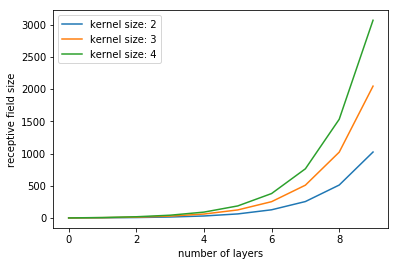

In [10]:
def _receptive_field_size_temporal_conv_net_(kernel_size, n_layers):
    return 1 + 2 * (kernel_size - 1) * (2 ** n_layers - 1)

for k in range(2, 5):
    plt.plot([_receptive_field_size_temporal_conv_net_(kernel_size=k, n_layers=n) for n in range(10)], label=f"kernel size: {k}")
plt.xlabel('number of layers')
plt.ylabel('receptive field size')
plt.legend()

## training

In [11]:
LatentSpaceEncoding = namedtuple('LatentSpaceEncoding', 'mean var')

def get_latent_space(model, X):
    def _encode_(x):
        if hasattr(model, 'encode'):
            # normal model
            return model.encode(x)
        else:
            # only encoder/inference net
            return model(x)
        
    if model.__class__ in [DrosophVAEConv, DrosophVAESkipConv]:
        return LatentSpaceEncoding(*map(lambda x: x.numpy(), _encode_(X)))
    else:
        return LatentSpaceEncoding(*map(lambda x: x.numpy()[back_to_single_time], _encode_(X)))
    
    
def _reshape_and_rescale_(X, scaler=scaler, data_type=run_cfg['data_type']):
    """To be defined in this notebook / function. Basically a larger lambda function
    """
    rescaled = scaler.inverse_transform(X)
    if data_type ==  config.DataType.POS_2D:
        return rescaled.reshape(-1, 15, 2)
    elif data_type ==  config.DataType.ANGLE_3D:
        return rescaled
    else:
        raise ValueError(f"uh, got something odd: {data_type}")
        
def same_experiment_same_fly(exp_0, exp_1):
    keys_0 = experiment_key(obj=exp_0).split('-')
    keys_1 = experiment_key(obj=exp_1).split('-')
    return keys_0[0] == keys_1[0] and keys_0[2] == keys_1[2]

In [12]:
reload(vae_training)
reload(supervised_training)

<module 'drosoph_vae.training.supervised' from '/home/samuel/SOM-VAE/drosoph_vae/training/supervised.py'>

In [13]:
from sklearn.metrics import adjusted_mutual_info_score, homogeneity_score, silhouette_score, normalized_mutual_info_score
from drosoph_vae.settings.data import Experiment, experiment_key

def eval_model(training_results, X, X_eval, y, y_frames, run_config, supervised=False, best=False, back_to_single_time=None):
    #
    # Unsupervised part
    #
    
    model = training_results['model']
    exp_desc = run_config.description(short=False)
    exp_desc_short = run_config.description()
    X_hat_eval = _reshape_and_rescale_(model(X).numpy()[back_to_single_time], data_type=run_config['data_type'])
    epochs = len(training_results['train_reports'])
    
    if supervised:
        exp_desc_short = 'supervised_' + exp_desc_short
        
    if best:
        exp_desc_short = 'best_' + exp_desc_short

    
    #
    # Reconstruction plots
    #
    
    if run_config['data_type'] == config.DataType.ANGLE_3D:
        plot_recon_path = plots.plot_reconstruction_comparision_angle_3d(X_eval, X_hat_eval, 
                                                                         epochs=epochs, 
                                                                         selected_columns=selected_columns,
                                                                         run_desc=exp_desc_short)
    else:
        plot_recon_path = plots.plot_reconstruction_comparision_pos_2d(X_eval, X_hat_eval, 
                                                                 epochs=epochs, 
                                                                 run_desc=exp_desc_short)
        
    #
    # Latent plot
    #

    X_latent = get_latent_space(training_results['model'], X)
    X_latent_mean_tsne_proj = TSNE(n_components=2, random_state=42).fit_transform(np.hstack((X_latent.mean, X_latent.var)))

    #cluster_assignments = HDBSCAN(min_cluster_size=8).fit_predict(np.hstack((X_latent.mean, X_latent.var)))
    # average because of the triplet loss (maybe? kinda makes sense... not?)
    cluster_assignments = AgglomerativeClustering(n_clusters=2 * len(list(config.Behavior)), linkage='average')\
        .fit_predict(np.hstack((X_latent.mean, X_latent.var)))
                                                                                      
    plot_latent_path = plots.plot_latent_space(X_latent,
                                         X_latent_mean_tsne_proj,
                                         np.array([y.label.name for _, y in y_frames[back_to_single_time]]),
                                         cluster_assignments,
                                         exp_desc_short,
                                         epochs=len(training_results['train_reports']))
    
    #
    # Videos
    #
    group_videos = list(video.group_video_of_clusters(cluster_assignments,
                                                      y_frames[back_to_single_time],
                                                      exp_desc_short, 
                                                      epochs=epochs))
    
    #nmi = normalized_mutual_information(cluster_assignments, y)
    #pur = purity(cluster_assignments, y)
    silhouette = silhouette_score(np.hstack((X_latent.mean, X_latent.var)), y[:, -1])
    adjusted_mutual_info = adjusted_mutual_info_score(y[:, -1], cluster_assignments)
    homogeneity = homogeneity_score(y[:, -1], cluster_assignments)
    mutual_info = normalized_mutual_info_score(y[:, -1], cluster_assignments)
    
    #
    # Single video of Hubert, the special fly
    # NOTE that the data is altered here
    #

    hubert = Experiment(**SetupConfig.value('hubert'))
    hubert_idx = np.array([same_experiment_same_fly(l, hubert) for l in y_frames[back_to_single_time][:, 1]])

    exp_descs = np.array([experiment_key(obj=l) for l in y_frames[back_to_single_time][:, 1]])

    X_hat_eval = X_hat_eval[hubert_idx, :]
    cluster_assignments = cluster_assignments[hubert_idx]
    image_id_with_exp = y_frames[back_to_single_time][hubert_idx]
    paths = [video._path_for_image_(image_id, label) for image_id, label in image_id_with_exp]

    labels = [l.label.name for l in y_frames[back_to_single_time][hubert_idx, 1]]
    
    if run_config['data_type'] == config.DataType.POS_2D:
        mean_, std_ = normalisation_factors[experiment_key(obj=hubert)]
        X_hat_eval = (X_hat_eval *std_) + mean_

        X_raw_input = (frame_data.reshape(-1, 15, 2) * std_) + mean_
        X_raw_input = X_raw_input[y_frames[back_to_single_time][:, 0].astype(np.int)]
        X_hat_eval = np.clip(X_hat_eval, np.min(X_raw_input), np.max(X_raw_input)) # some odd errors otherwise

        full_video_path = video.comparision_video_of_reconstruction((X_raw_input, X_hat_eval), 
                                                                    cluster_assignments,
                                                                    image_id_with_exp,
                                                                    labels,
                                                                    n_train_data_points,
                                                                    paths,
                                                                    epochs=epochs,
                                                                    run_desc=exp_desc_short)
    else:
        full_video_path = video.comparision_video_of_reconstruction([],
                                                                    cluster_assignments,
                                                                    image_id_with_exp,
                                                                    labels,
                                                                    n_train_data_points,
                                                                    paths,
                                                                    epochs=epochs,
                                                                    run_desc=exp_desc_short)
        
    

    return {'latent_projection': X_latent_mean_tsne_proj, 
            'cluster_assignments': cluster_assignments,
            'plot_paths': {'reconstruction': plot_recon_path, 'latent': plot_latent_path},
            'video_paths': {'groups': group_videos, 'hubert': full_video_path},
            'scores': {
                'silhouette': silhouette,
                'adjusted_mutual_info': adjusted_mutual_info,
                'homogeneity': homogeneity,
                'mutual_info': mutual_info
            }
           }

In [14]:
#if run_cfg['use_time_series']:
#    X_train, X_test, y_train, y_test, frame_labels_train, frame_labels_test = [misc.to_time_series_np(x, sequence_length=run_cfg['time_series_length']) 
#                                        for x in (X_train, X_test, y_train, y_test, frame_labels_train, frame_labels_test)]
#
#X = np.vstack((X_train, X_test))
#y = np.vstack((y_train, y_test))
#y_frames = np.vstack((frame_labels_train, frame_labels_test))
#
#train_dataset = to_tf_data(X_train, y_train, batch_size=run_cfg['batch_size'])
#test_dataset = to_tf_data(X_test, y_test, batch_size=run_cfg['batch_size']) 
#
#if run_cfg['use_time_series']:
#    back_to_single_time = np.s_[:, -1, :]
#else:
#    back_to_single_time = np.s_[:]
#    
#X_eval = _reshape_and_rescale_(X[back_to_single_time])

In [15]:
from itertools import product

def grid_search(grid_search_params, raw_data):
    parameters = product(*grid_search_params.values())
    # it's important that it is a generator, tensorflow might complain overwise 
    # too many writers and such, depends heavily on the computer
    cfgs = ((p, config.RunConfig(**dict(zip(grid_search_params.keys(), p)))) for p in parameters)
    
    vae_n_epochs = SetupConfig.value('training', 'vae', 'n_epochs')
    vae_n_epochs_eval = SetupConfig.value('training', 'vae', 'n_epochs_eval')
    supervised_n_epochs = SetupConfig.value('training', 'supervised', 'n_epochs')
    supervised_n_epochs_eval = SetupConfig.value('training', 'supervised', 'n_epochs_eval')
        
    for p, cfg in cfgs:
        if cfg['use_time_series']:
            X_train, X_test, y_train, y_test, frame_labels_train, frame_labels_test = [misc.to_time_series_np(x, sequence_length=cfg['time_series_length']) 
                                                for x in (raw_data)]

        X = np.vstack((X_train, X_test))
        y = np.vstack((y_train, y_test))
        y_frames = np.vstack((frame_labels_train, frame_labels_test))

        train_dataset = to_tf_data(X_train, y_train, batch_size=cfg['batch_size'])
        test_dataset = to_tf_data(X_test, y_test, batch_size=cfg['batch_size']) 

        if cfg['use_time_series']:
            back_to_single_time = np.s_[:, -1, :]
        else:
            back_to_single_time = np.s_[:]

        X_eval = _reshape_and_rescale_(X[back_to_single_time])
        #
        # Unsupervised part
        #
        
        # not the best code, but it needs to run... some results are better than none
        try:
            # this allows continuous training with a fixed number of epochs. uuuh yeah.
            # there is however a side-effect problem here. I am running this on a GPU, `init` and `train` need to be called in order.
            # it needs to be init->train, init->train, ... init resets the graph, and I guess this will free up memory
            vae_training_args = vae_training.init(input_shape=X_train.shape[1:], run_config=cfg)
            # model, losses, ...
            vae_training_results = {}
            # paths
            vae_eval_results = []
            for u in range(np.int(vae_n_epochs/ vae_n_epochs_eval)):
                vae_training_results = vae_training.train(**{**vae_training_args, **vae_training_results},
                                                          train_dataset=train_dataset, 
                                                          test_dataset=test_dataset,
                                                          early_stopping=False,
                                                          n_epochs=vae_n_epochs_eval)

                vae_eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, cfg, back_to_single_time=back_to_single_time)]
                #for n, p in vae_eval_results[-1]['plot_paths'].items():
                #    tf_helpers.tf_write_image(vae_training_args['test_summary_writer'], n, p, vae_training_results['train_reports'].shape[0])

        except Exception:
            print(f"problem with unsupervised {vae_training_args}: {traceback.format_exc()}")
            continue
            
        try:
            base_mdl = vae_training_results['model'].__class__(**vae_training_args['model_config'])
            base_mdl.load_weights(vae_training_args['model_checkpoints_path'])

            vae_training_results['model'] = base_mdl
            vae_best = eval_model(vae_training_results, X, X_eval, y, y_frames, cfg, best=True, back_to_single_time=back_to_single_time)
        except Exception:
            print(f"problem with loading the model: {traceback.format_exc()}")
            continue
        #
        # Supervised part
        # 
        
        try:
            # the training process saves the model with the min loss.
            
            supervised_training_args = supervised_training.init(model=base_mdl.inference_net, run_config=cfg)
            supervised_training_results = {}
            supervised_eval_results = []
            
            for u in range(np.int(supervised_n_epochs/ supervised_n_epochs_eval)):
                supervised_training_results = supervised_training.train(**{**supervised_training_args, **supervised_training_results},
                                                          train_dataset=train_dataset, 
                                                          test_dataset=test_dataset,
                                                          early_stopping=False,
                                                          n_epochs=supervised_n_epochs_eval)

                base_mdl.inference_net = supervised_training_results['model']
                supervised_training_results['model'] = base_mdl 
                supervised_eval_results += [eval_model(supervised_training_results, X, X_eval, y, y_frames, cfg, supervised=True, back_to_single_time=back_to_single_time)]
                supervised_training_results['model'] = base_mdl.inference_net

            
            # it always saves the full model
            base_mdl.load_weights(vae_training_args['model_checkpoints_path'])
            base_mdl.inference_net.load_weights(supervised_training_args['model_checkpoints_path'])
            supervised_training_results['model'] = base_mdl 
            supervised_best = eval_model(supervised_training_results, X, X_eval, y, y_frames, cfg, supervised=True, best=True, back_to_single_time=back_to_single_time)
        except Exception:
            print(f"problem with supervised {vae_training_args}\n\t{supervised_training_args}\n\t{traceback.format_exc()}")
            continue
        
        # too many figures overwise (duh)
        plt.close('all')
        
        res = {'parameters': p,
               'vae': {'train_reports': vae_training_results['train_reports'], 
                       'test_reports':  vae_training_results['test_reports'],
                       'model_checkpoints_path': vae_training_args['model_checkpoints_path'],
                       'best_model_eval_results': vae_best,
                       'eval_results': vae_eval_results},
               'supervised': {'train_reports': supervised_training_results['train_reports'],
                              'test_reports':  supervised_training_results['test_reports'],
                              'model_checkpoints_path': supervised_training_args['model_checkpoints_path'],
                              'best_model_eval_results': supervised_best,
                              'eval_results': supervised_eval_results}}
        
        yield res

In [16]:
import logging

class NoParsingFilter(logging.Filter):
    def filter(self, record):
        return not ('input image is not divisible' in record.getMessage())

# such a pain in the ass
logger= logging.getLogger('imageio_ffmpeg')
logger.setLevel(logging.INFO)
logger.addFilter(NoParsingFilter())

In [17]:
from datetime import datetime
# Note that the data will be reused -> Don't adapt the data_type here. 
# Either include the data loading into the grid-search or make two runs, one for each DataType

grid_search_params = {
    'model_impl': [config.ModelType.SKIP_PADD_CONV],
    'latent_dim': [2, 4, ],
    'vae_learning_rate': [1e-4, 1e-6],
    'supervised_learning_rate': [1e-5, ],
    'time_series_length': [16, 32],
}

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    started_at = datetime.now().strftime("%Y%m%d-%H%M%S")
    if SetupConfig.runs_on_lab_server():
        grid_search_results = list(grid_search(grid_search_params, raw_data=raw_data))
        misc.dump_results(grid_search_results, f"grid_search_only_vae_{started_at}")
    else:
        grid_search_params = {
            'model_impl': [config.ModelType.SKIP_PADD_CONV], # config.ModelType.values(),
            'latent_dim': [2, ]
        }
        grid_search_results = list(grid_search(grid_search_params, raw_data=raw_data))
        misc.dump_results(grid_search_results, f"grid_search_only_vae_{started_at}")

Using model: ModelType.SKIP_PADD_CONV


2019-06-17 20:15:18,843 - tensorflow - WARNING - deprecation_wrapper - From /home/samuel/SOM-VAE/drosoph_vae/models/drosoph_vae.py:115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



Epoch: 0000, train/test loss: 1.884	 3.184 took 5.964 sec
Epoch: 0010, train/test loss: 1.767	 2.994 took 3.994 sec
Epoch: 0020, train/test loss: 1.722	 3.000 took 4.011 sec
Epoch: 0030, train/test loss: 1.608	 2.921 took 4.355 sec
Epoch: 0040, train/test loss: 1.506	 2.823 took 4.123 sec
Epoch: 0050, train/test loss: 1.429	 2.747 took 4.574 sec
Epoch: 0060, train/test loss: 1.383	 2.650 took 4.142 sec
Epoch: 0070, train/test loss: 1.355	 2.608 took 4.431 sec
Epoch: 0080, train/test loss: 1.335	 2.561 took 4.974 sec
Epoch: 0090, train/test loss: 1.319	 2.532 took 5.076 sec
Epoch: 0100, train/test loss: 1.303	 2.501 took 4.288 sec
Epoch: 0110, train/test loss: 1.289	 2.479 took 4.395 sec
Epoch: 0120, train/test loss: 1.276	 2.456 took 5.585 sec
Epoch: 0130, train/test loss: 1.265	 2.434 took 5.170 sec
Epoch: 0140, train/test loss: 1.254	 2.405 took 5.688 sec
Epoch: 0150, train/test loss: 1.244	 2.378 took 5.521 sec
Epoch: 0160, train/test loss: 1.236	 2.356 took 5.433 sec
Epoch: 0170, t

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0020, train/test loss: 0.992	 0.892 took 2.225 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0030, train/test loss: 0.991	 0.877 took 2.163 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0040, train/test loss: 0.990	 0.861 took 2.091 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

Using model: ModelType.SKIP_PADD_CONV
Epoch: 0000, train/test loss: 1.873	 3.232 took 12.743 sec
Epoch: 0010, train/test loss: 1.789	 3.083 took 10.681 sec
Epoch: 0020, train/test loss: 1.741	 3.015 took 10.579 sec
Epoch: 0030, train/test loss: 1.728	 2.994 took 11.466 sec
Epoch: 0040, train/test loss: 1.724	 2.982 took 11.098 sec
Epoch: 0050, train/test loss: 1.716	 2.963 took 10.811 sec
Epoch: 0060, train/test loss: 1.535	 2.645 took 10.361 sec
Epoch: 0070, train/test loss: 1.388	 2.527 took 10.932 sec
Epoch: 0080, train/test loss: 1.345	 2.489 took 11.009 sec
Epoch: 0090, train/test loss: 1.327	 2.476 took 11.660 sec
Epoch: 0100, train/test loss: 1.309	 2.471 took 10.875 sec
Epoch: 0110, train/test loss: 1.283	 2.469 took 10.643 sec
Epoch: 0120, train/test loss: 1.267	 2.477 took 11.563 sec
Epoch: 0130, train/test loss: 1.253	 2.503 took 10.957 sec
Epoch: 0140, train/test loss: 1.236	 2.494 took 11.180 sec
Epoch: 0150, train/test loss: 1.224	 2.502 took 10.817 sec
Epoch: 0160, train

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Epoch: 0170, train/test loss: 1.200	 2.507 took 10.900 sec
Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samue

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Epoch: 0180, train/test loss: 1.188	 2.513 took 11.131 sec
Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samue

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Epoch: 0190, train/test loss: 1.175	 2.514 took 10.833 sec
Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samue

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Error with KL-loss {'Traceback (most recent call last):\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py", line 185, in inf_nan_callback\n    check_numerics_op_attrs, 1)\ntensorflow.python.eager.core._NotOkStatusException: InvalidArgumentError: Eager-mode inf/nan check : Tensor had Inf values [Op:CheckNumerics]\n\nDuring handling of the above exception, another exception occurred:\n\nTraceback (most recent call last):\n  File "/home/samuel/SOM-VAE/drosoph_vae/losses/vae_loss.py", line 57, in compute_loss\n    kl = tf.reduce_mean(tf.clip_by_value(tfp.distributions.kl_divergence(p, q, allow_nan_stats=True), 0., 1e32))\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow_probability/python/distributions/kullback_leibler.py", line 96, in kl_divergence\n    kl_t = kl_fn(distribution_a, distribution_b, name=name)\n  File "/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensor

Epoch: 0000, train/test loss: 0.991	 1.000 took 4.548 sec
Epoch: 0010, train/test loss: 0.989	 1.000 took 4.191 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0020, train/test loss: 0.986	 1.000 took 4.117 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0030, train/test loss: 0.985	 1.000 took 4.224 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0040, train/test loss: 0.984	 1.000 took 4.145 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

Using model: ModelType.SKIP_PADD_CONV
Epoch: 0000, train/test loss: 1.880	 3.003 took 5.698 sec
Epoch: 0010, train/test loss: 1.881	 3.080 took 5.185 sec
Epoch: 0020, train/test loss: 1.892	 3.093 took 5.328 sec
Epoch: 0030, train/test loss: 1.876	 3.122 took 5.039 sec
Epoch: 0040, train/test loss: 1.883	 3.083 took 5.345 sec
Epoch: 0050, train/test loss: 1.877	 3.039 took 5.334 sec
Epoch: 0060, train/test loss: 1.871	 2.997 took 5.464 sec
Epoch: 0070, train/test loss: 1.872	 3.103 took 5.352 sec
Epoch: 0080, train/test loss: 1.870	 3.051 took 5.131 sec
Epoch: 0090, train/test loss: 1.878	 3.069 took 5.531 sec
Epoch: 0100, train/test loss: 1.876	 3.034 took 5.250 sec
Epoch: 0110, train/test loss: 1.869	 3.084 took 5.139 sec
Epoch: 0120, train/test loss: 1.862	 3.074 took 5.404 sec
Epoch: 0130, train/test loss: 1.873	 3.012 took 6.713 sec
Epoch: 0140, train/test loss: 1.862	 3.058 took 5.488 sec
Epoch: 0150, train/test loss: 1.867	 3.074 took 5.578 sec
Epoch: 0160, train/test loss: 1.86

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0020, train/test loss: 1.000	 1.000 took 2.131 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0030, train/test loss: 1.000	 1.000 took 2.233 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0040, train/test loss: 1.000	 1.000 took 2.162 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

Using model: ModelType.SKIP_PADD_CONV
Epoch: 0000, train/test loss: 1.893	 3.147 took 11.875 sec
Epoch: 0010, train/test loss: 1.906	 3.113 took 10.910 sec
Epoch: 0020, train/test loss: 1.900	 3.100 took 12.487 sec
Epoch: 0030, train/test loss: 1.900	 3.105 took 10.888 sec
Epoch: 0040, train/test loss: 1.894	 3.117 took 10.902 sec
Epoch: 0050, train/test loss: 1.901	 3.132 took 11.287 sec
Epoch: 0060, train/test loss: 1.880	 3.101 took 10.838 sec
Epoch: 0070, train/test loss: 1.890	 3.123 took 11.154 sec
Epoch: 0080, train/test loss: 1.886	 3.110 took 10.647 sec
Epoch: 0090, train/test loss: 1.891	 3.143 took 11.048 sec
Epoch: 0100, train/test loss: 1.883	 3.125 took 11.100 sec
Epoch: 0110, train/test loss: 1.893	 3.115 took 10.942 sec
Epoch: 0120, train/test loss: 1.891	 3.123 took 11.047 sec
Epoch: 0130, train/test loss: 1.883	 3.107 took 11.154 sec
Epoch: 0140, train/test loss: 1.882	 3.123 took 11.099 sec
Epoch: 0150, train/test loss: 1.882	 3.120 took 10.720 sec
Epoch: 0160, train

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0020, train/test loss: 1.000	 1.000 took 4.173 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0030, train/test loss: 1.000	 1.000 took 4.117 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0040, train/test loss: 1.000	 1.000 took 4.274 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

Using model: ModelType.SKIP_PADD_CONV
Epoch: 0000, train/test loss: 1.877	 3.064 took 5.852 sec
Epoch: 0010, train/test loss: 1.770	 3.000 took 5.405 sec
Epoch: 0020, train/test loss: 1.665	 2.673 took 5.253 sec
Epoch: 0030, train/test loss: 1.542	 2.374 took 5.218 sec
Epoch: 0040, train/test loss: 1.435	 2.237 took 5.384 sec
Epoch: 0050, train/test loss: 1.356	 2.229 took 5.364 sec
Epoch: 0060, train/test loss: 1.322	 2.233 took 5.237 sec
Epoch: 0070, train/test loss: 1.304	 2.228 took 5.563 sec
Epoch: 0080, train/test loss: 1.293	 2.224 took 5.518 sec
Epoch: 0090, train/test loss: 1.282	 2.220 took 5.342 sec
Epoch: 0100, train/test loss: 1.273	 2.215 took 5.448 sec
Epoch: 0110, train/test loss: 1.265	 2.206 took 5.566 sec
Epoch: 0120, train/test loss: 1.256	 2.195 took 5.292 sec
Epoch: 0130, train/test loss: 1.247	 2.190 took 5.431 sec
Epoch: 0140, train/test loss: 1.236	 2.182 took 5.364 sec
Epoch: 0150, train/test loss: 1.224	 2.175 took 5.342 sec
Epoch: 0160, train/test loss: 1.21

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0020, train/test loss: 0.990	 0.977 took 2.081 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0030, train/test loss: 0.982	 0.955 took 2.141 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0040, train/test loss: 0.981	 0.952 took 2.206 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

Using model: ModelType.SKIP_PADD_CONV
Epoch: 0000, train/test loss: 1.914	 3.150 took 11.737 sec
Epoch: 0010, train/test loss: 1.801	 3.029 took 10.776 sec
Epoch: 0020, train/test loss: 1.756	 2.978 took 10.899 sec
Epoch: 0030, train/test loss: 1.736	 2.967 took 10.956 sec
Epoch: 0040, train/test loss: 1.730	 2.970 took 10.801 sec
Epoch: 0050, train/test loss: 1.581	 2.630 took 10.920 sec
Epoch: 0060, train/test loss: 1.488	 2.487 took 10.909 sec
Epoch: 0070, train/test loss: 1.420	 2.466 took 10.972 sec
Epoch: 0080, train/test loss: 1.369	 2.452 took 10.619 sec
Epoch: 0090, train/test loss: 1.351	 2.445 took 11.040 sec
Epoch: 0100, train/test loss: 1.340	 2.446 took 13.796 sec
Epoch: 0110, train/test loss: 1.331	 2.444 took 11.322 sec
Epoch: 0120, train/test loss: 1.322	 2.436 took 10.979 sec
Epoch: 0130, train/test loss: 1.313	 2.430 took 10.983 sec
Epoch: 0140, train/test loss: 1.298	 2.429 took 11.012 sec
Epoch: 0150, train/test loss: 1.281	 2.428 took 11.082 sec
Epoch: 0160, train

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0020, train/test loss: 0.988	 1.000 took 4.002 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0030, train/test loss: 0.988	 1.000 took 4.089 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0040, train/test loss: 0.987	 1.000 took 4.149 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

Using model: ModelType.SKIP_PADD_CONV
Epoch: 0000, train/test loss: 1.911	 3.107 took 6.083 sec
Epoch: 0010, train/test loss: 1.918	 3.030 took 5.368 sec
Epoch: 0020, train/test loss: 1.910	 3.252 took 5.428 sec
Epoch: 0030, train/test loss: 1.917	 3.104 took 5.372 sec
Epoch: 0040, train/test loss: 1.905	 3.013 took 5.328 sec
Epoch: 0050, train/test loss: 1.912	 3.100 took 5.478 sec
Epoch: 0060, train/test loss: 1.908	 3.075 took 5.441 sec
Epoch: 0070, train/test loss: 1.889	 3.037 took 5.451 sec
Epoch: 0080, train/test loss: 1.900	 3.048 took 5.330 sec
Epoch: 0090, train/test loss: 1.896	 2.983 took 5.496 sec
Epoch: 0100, train/test loss: 1.898	 2.998 took 5.503 sec
Epoch: 0110, train/test loss: 1.881	 3.162 took 5.556 sec
Epoch: 0120, train/test loss: 1.900	 3.049 took 5.393 sec
Epoch: 0130, train/test loss: 1.904	 3.151 took 5.376 sec
Epoch: 0140, train/test loss: 1.892	 3.116 took 5.571 sec
Epoch: 0150, train/test loss: 1.904	 3.193 took 5.527 sec
Epoch: 0160, train/test loss: 1.89

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0020, train/test loss: 1.000	 1.000 took 2.122 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0030, train/test loss: 1.000	 1.000 took 2.122 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0040, train/test loss: 1.000	 1.000 took 2.082 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

Using model: ModelType.SKIP_PADD_CONV
Epoch: 0000, train/test loss: 2.065	 3.381 took 11.593 sec
Epoch: 0010, train/test loss: 2.080	 3.502 took 10.878 sec
Epoch: 0020, train/test loss: 2.046	 3.464 took 10.697 sec
Epoch: 0030, train/test loss: 2.063	 3.390 took 10.408 sec
Epoch: 0040, train/test loss: 2.066	 3.425 took 10.872 sec
Epoch: 0050, train/test loss: 2.040	 3.380 took 10.756 sec
Epoch: 0060, train/test loss: 2.034	 3.394 took 15.218 sec
Epoch: 0070, train/test loss: 2.041	 3.370 took 10.832 sec
Epoch: 0080, train/test loss: 2.047	 3.357 took 10.834 sec
Epoch: 0090, train/test loss: 2.057	 3.350 took 11.084 sec
Epoch: 0100, train/test loss: 2.013	 3.310 took 10.978 sec
Epoch: 0110, train/test loss: 2.038	 3.325 took 11.049 sec
Epoch: 0120, train/test loss: 2.022	 3.312 took 10.908 sec
Epoch: 0130, train/test loss: 2.008	 3.348 took 11.073 sec
Epoch: 0140, train/test loss: 2.016	 3.344 took 11.184 sec
Epoch: 0150, train/test loss: 2.005	 3.298 took 11.159 sec
Epoch: 0160, train

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0020, train/test loss: 1.000	 1.000 took 4.129 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0030, train/test loss: 1.000	 1.000 took 4.263 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 0040, train/test loss: 1.000	 1.000 took 4.020 sec


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

In [29]:
len(grid_search_results)

8

In [30]:
[g['parameters'] for g in grid_search_results]

[(<ModelType.SKIP_PADD_CONV: 2>, 2, 0.0001, 1e-05, 16),
 (<ModelType.SKIP_PADD_CONV: 2>, 2, 0.0001, 1e-05, 32),
 (<ModelType.SKIP_PADD_CONV: 2>, 2, 1e-06, 1e-05, 16),
 (<ModelType.SKIP_PADD_CONV: 2>, 2, 1e-06, 1e-05, 32),
 (<ModelType.SKIP_PADD_CONV: 2>, 4, 0.0001, 1e-05, 16),
 (<ModelType.SKIP_PADD_CONV: 2>, 4, 0.0001, 1e-05, 32),
 (<ModelType.SKIP_PADD_CONV: 2>, 4, 1e-06, 1e-05, 16),
 (<ModelType.SKIP_PADD_CONV: 2>, 4, 1e-06, 1e-05, 32)]

In [20]:
_t =[[er['scores'] for er in gsr['vae']['eval_results']] for gsr in grid_search_results]

In [21]:
_t

[[{'silhouette': 0.14520015,
   'adjusted_mutual_info': 0.1556504348908415,
   'homogeneity': 0.36226687836765686,
   'mutual_info': 0.24002538790720276},
  {'silhouette': 0.37377942,
   'adjusted_mutual_info': 0.23307039136139798,
   'homogeneity': 0.47176881135017545,
   'mutual_info': 0.3340439595852118},
  {'silhouette': 0.36702576,
   'adjusted_mutual_info': 0.2287297128436987,
   'homogeneity': 0.4946447972935901,
   'mutual_info': 0.33875263368701675},
  {'silhouette': 0.36061883,
   'adjusted_mutual_info': 0.24669276487185993,
   'homogeneity': 0.49208933885820133,
   'mutual_info': 0.3508368159938656},
  {'silhouette': 0.35865515,
   'adjusted_mutual_info': 0.2631501603064889,
   'homogeneity': 0.504093571470963,
   'mutual_info': 0.36671215956509406},
  {'silhouette': 0.34054524,
   'adjusted_mutual_info': 0.2819027306803339,
   'homogeneity': 0.5073175100820153,
   'mutual_info': 0.3806882091510381},
  {'silhouette': 0.32586345,
   'adjusted_mutual_info': 0.24016352273446692

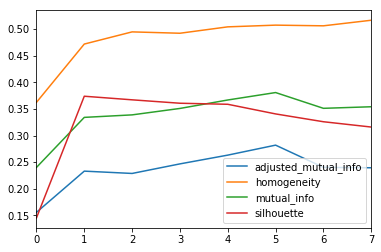

In [22]:
pd.DataFrame(_t[0]).plot()

In [23]:
def _extract_(res):
    return (res['train_reports'], res['test_reports'])



In [24]:
grid_search_params_as_list = list(product(grid_search_params))

In [25]:
grid_search_params_as_list

[('model_impl',),
 ('latent_dim',),
 ('vae_learning_rate',),
 ('supervised_learning_rate',),
 ('time_series_length',)]

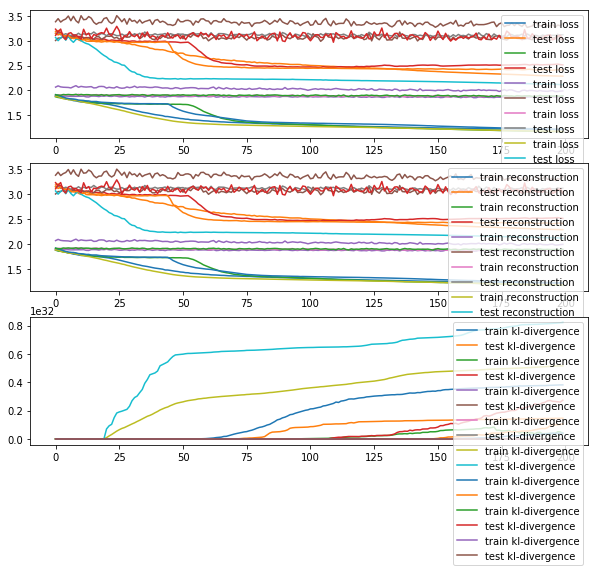

In [26]:
# plot_data = [parameters, train_reports, test_reports]
plot_data = [(res['parameters'], *_extract_(res['vae'])) for res in grid_search_results]
losses = ['loss', 'reconstruction', 'kl-divergence']
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
for params, train_losses, test_losses in plot_data:
    for i, l in enumerate(losses):
        axs[i].plot(train_losses[:, i], label=f"train {l}")
        axs[i].plot(test_losses[:, i], label=f"test {l}")
        
for a in axs:
    a.legend()

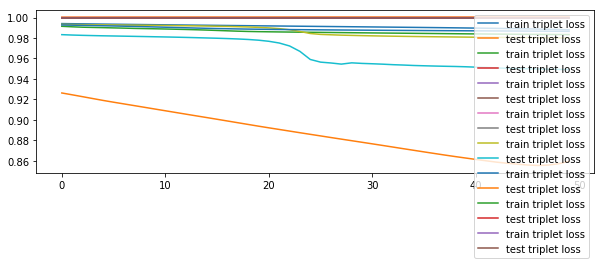

In [27]:
# plot_data = [parameters, train_reports, test_reports]
plot_data = [(res['parameters'], *_extract_(res['supervised'])) for res in grid_search_results]
losses = ['triplet loss']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
for params, train_losses, test_losses in plot_data:
    ax.plot(train_losses, label=f"train triplet loss")
    ax.plot(test_losses, label=f"test triplet loss")
        
plt.legend()

In [28]:
stop

NameError: name 'stop' is not defined

In [33]:
grid_search_results[0]['vae']

{'train_reports': array([[1.88389682e+00, 1.88389682e+00, 1.80965632e-01],
        [1.86661611e+00, 1.86661611e+00, 1.88796417e-01],
        [1.85368735e+00, 1.85368735e+00, 1.97907601e-01],
        [1.84472246e+00, 1.84472246e+00, 2.09078586e-01],
        [1.83326854e+00, 1.83326854e+00, 2.23577526e-01],
        [1.82172185e+00, 1.82172185e+00, 2.42726442e-01],
        [1.80978862e+00, 1.80978862e+00, 2.70942913e-01],
        [1.79375483e+00, 1.79375483e+00, 3.17814570e-01],
        [1.78771636e+00, 1.78771636e+00, 4.07703229e-01],
        [1.77625748e+00, 1.77625748e+00, 6.31104919e-01],
        [1.76734501e+00, 1.76734501e+00, 1.24755014e+00],
        [1.76469913e+00, 1.76469913e+00, 2.19573811e+00],
        [1.75817425e+00, 1.75817425e+00, 2.08160832e+00],
        [1.75105713e+00, 1.75105713e+00, 2.23584962e+00],
        [1.75100346e+00, 1.75100346e+00, 3.12352488e+00],
        [1.74972379e+00, 1.74972379e+00, 4.74381547e+00],
        [1.74367714e+00, 1.74367714e+00, 5.62052068e+00

In [ ]:
grid_search_results[0]['vae']['eval_results'][0]['scores']

In [ ]:
len(grid_search_results[0]['vae']['eval_results'])

In [ ]:
stop

In [ ]:
reload(tf_helpers)
reload(vae_training)
reload(video)

In [ ]:
#if not SetupConfig.runs_on_lab_server():
#    reload(vae_training)
#    epochs = 14
#    eval_steps = 7
#    run_cfg['latent_dim'] = 6
#    vae_training_args = vae_training.init(input_shape=X_train.shape[1:], run_config=run_cfg)
#    vae_training_results = {}
#    eval_results = []
#    for u in range(np.int(epochs / eval_steps)):
#        vae_training_results = vae_training.train(**{**vae_training_args, **vae_training_results},
#                                                  train_dataset=train_dataset, 
#                                                  test_dataset=test_dataset,
#                                                  early_stopping=False,
#                                                  n_epochs=eval_steps)
#
#        eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, run_cfg)]
#
#    eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, run_cfg)]

In [ ]:
reload(supervised_training)

cfg = RunConfig(model_impl=config.ModelType.SKIP_PADD_CONV, latent_dim=1)
vae_training_args = vae_training.init(input_shape=X_train.shape[1:], run_config=cfg)
vae_training_results = {}
vae_eval_results = []
epochs = 14
eval_steps = 7

try:
    for u in range(np.int(epochs / eval_steps)):
            vae_training_results = vae_training.train(**{**vae_training_args, **vae_training_results},
                                                      train_dataset=train_dataset, 
                                                      test_dataset=test_dataset,
                                                      early_stopping=False,
                                                      n_epochs=eval_steps)

            vae_eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, cfg)]
        #for n, p in vae_eval_results[-1]['plot_paths'].items():
        #    tf_helpers.tf_write_image(vae_training_args['test_summary_writer'], n, p, vae_training_results['train_reports'].shape[0])

    vae_eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, cfg)]
except Exception:
    print(f"problem with {vae_training_args}: {traceback.format_exc()}")


# the training process saves the model with the min loss.
base_mdl = vae_training_results['model'].__class__(**vae_training_args['model_config'])
base_mdl.load_weights(vae_training_args['model_checkpoints_path'])

supervised_training_args = supervised_training.init(model=base_mdl.inference_net, run_config=cfg)
supervised_training_results = {}
supervised_eval_results = []

for u in range(np.int(epochs / eval_steps)):
    supervised_training_results = supervised_training.train(**{**supervised_training_args, **supervised_training_results},
                                              train_dataset=train_dataset, 
                                              test_dataset=test_dataset,
                                              early_stopping=False,
                                              n_epochs=eval_steps)

    base_mdl.inference_net = supervised_training_results['model']
    supervised_training_results['model'] = base_mdl 
    supervised_eval_results += [eval_model(supervised_training_results, X, X_eval, y, y_frames, cfg)]
    supervised_training_results['model'] = base_mdl.inference_net

base_mdl.inference_net = supervised_training_results['model']
supervised_training_results['model'] = base_mdl 
supervised_eval_results += [eval_model(supervised_training_results, X, X_eval, y, y_frames, cfg)]
supervised_training_results['model'] = base_mdl.inference_net

In [ ]:
base_mdl.inference_net.layers[1].summary()

In [ ]:
X[back_to_single_time].shape

In [ ]:
supervised_training_args['model'](X)

In [ ]:
X.shape

In [ ]:
get_latent_space(supervised_training_results['model'], X)
#     17         return LatentSpaceEncoding(*map(lambda x: x.numpy(), model.encode(X)))
#     18     else:
#---> 19         return LatentSpaceEncoding(*map(lambda x: x.numpy()[back_to_single_time], model.encode(X)))

In [ ]:
a = tf.zeros((128, 16, 4))
b = tf.zeros((128, 16, 4))

In [ ]:
tf.concat((a, b), axis=-1).shape

In [ ]:
eval_results

In [ ]:
vae_training_results['test_reports'][:, 0]

In [ ]:
vae_training

In [ ]:
eval_model(vae_training_results, X, X_eval, y, y_frames, run_cfg)

In [ ]:
from drosoph_vae.settings.data import Experiment, experiment_key
from PIL import Image

In [ ]:
base_mdl = vae_training_results['model'].__class__(latent_dim=run_cfg['latent_dim'], 
                                                   input_shape=X_train.shape[1:],
                                                   batch_size=run_cfg['batch_size'])
base_mdl.load_weights(vae_training_args['model_checkpoints_path'])

X_hat = base_mdl(X).numpy()[back_to_single_time]
X_hat = _reshape_and_rescale_(X_hat, data_type=run_cfg['data_type'])

cluster_assignments = AgglomerativeClustering(n_clusters=2 * len(list(config.Behavior)), linkage='average')\
        .fit_predict(X_encoded)

hubert = Experiment(**SetupConfig.value('hubert'))
hubert_idx = np.array([same_experiment_same_fly(l, hubert) for l in y_frames[back_to_single_time][:, 1]])

exp_descs = np.array([experiment_key(obj=l) for l in y_frames[back_to_single_time][:, 1]])

X_hat = X_hat[hubert_idx, :]
cluster_assignments = cluster_assignments[hubert_idx]
image_id_with_exp = y_frames[back_to_single_time][hubert_idx]
paths = [video._path_for_image_(image_id, label) for image_id, label in image_id_with_exp]

labels = [l.label.name for l in y_frames[back_to_single_time][hubert_idx, 1]]
mean_, std_ = normalisation_factors[experiment_key(obj=hubert)]
X_hat = (X_hat *std_) + mean_

_t = frame_data.reshape(-1, 15, 2)
X_raw_input = np.vstack((_t[run_cfg['time_series_length'] - 1:n_train_data_points], _t[n_train_data_points + run_cfg['time_series_length'] -1:]))

X_raw_input = (X_raw_input * std_) + mean_
X_raw_input = X_raw_input[y_frames[back_to_single_time][:, 0].astype(np.int)][hubert_idx]
X_hat = np.clip(X_hat, np.min(X_raw_input), np.max(X_raw_input)) # some odd errors otherwise

comparision_video_of_reconstruction((X_raw_input, X_hat), cluster_assignments, image_id_with_exp, labels, n_train_data_points, paths, run_desc=run_cfg.description())

In [ ]:
import cv2

In [ ]:
display_video('./tryout.mp4')

In [ ]:
X_encoded = np.hstack([t.numpy() for t in base_mdl.encode(X)])

In [ ]:
SetupConfig.value('fly_image_template')

In [ ]:
X_eval.shape

In [ ]:
normalisation_factors.keys()

In [ ]:
stop

# evaluation

In [ ]:
#if run_cfg['data_type'] == config.DataType.POS_2D:
#    fig = plots.plot_comparing_joint_position_with_reconstructed(X_eval,
#                                                                 X_hat_eval,
#                                                                 X_gen_eval,
#                                                                 validation_cut_off=n_train_data_points,
#                                                                 exp_desc=exp_desc_short);
#else:
#    # ncols is an ugly hack... it works on the basis that we have three working angles for each leg
#    if run_cfg['use_single_fly']:
#        start = 0
#        end = len(X_eval)
#    else:
#        start = 100
#        end = 1000
#    xticks = np.arange(start, end) / SetupConfig.value('frames_per_second') / 60.
#    if run_cfg['debug']:
#        _input_data = X[:, :, 0]
#        _recon = model(X, apply_sigmoid=False).numpy()[:, :, 0]
#        fig, axs = plt.subplots(nrows=_input_data.shape[-1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
#        for i in range(_input_data.shape[-1]):
#            _idx_ = np.s_[start:end, i]
#            axs[i].plot(xticks, _input_data[_idx_], label='input')
#            axs[i].plot(xticks, _recon[_idx_], label='reconstructed')
#    else:
#        fig, axs = plt.subplots(nrows=X_eval.shape[1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
#        for i, cn in enumerate(SD.get_3d_columns_names(selected_cols)):
#            _idx_ = np.s_[start:end, i]
#            axs[i].plot(xticks, X_eval[_idx_], label='input')
#            axs[i].plot(xticks, reconstructed_data[_idx_], label='reconstructed')
#
#            axs[i].set_title(cn)
#
#    axs[-1].set_xlabel('time [min]')
#    axs[0].legend(loc='upper left')
#    
#    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.suptitle(f"Comparision of selection of data\n({exp_desc})")
#    
#    plt.tight_layout()
#    plt.subplots_adjust(top=0.94)
#    plt.savefig(f"./figures/{exp_desc_short}_input_gen_recon_comparision.png")

# Latent space

In [ ]:
#plot_latent_space(X_latent, X_latent_mean_tsne_proj, y, run_cfg, epochs=len(vae_training_results['train_reports']))

In [ ]:
#from matplotlib.collections import LineCollection
#
#def plot_debug(input_data, cluster_assignments, cluster_colors=None):
#    _clusters = np.unique(cluster_assignments)
#    _colors = sns.color_palette(n_colors=len(_clusters))
#    if cluster_colors is None:
#        cluster_colors = dict(zip(_clusters, _colors))
#        
#    lines, colors = zip(*[([(x, input_data[x, 0]) for x in segment], cluster_colors[cluster_id])
#                           for cluster_id, segments in video.group_by_cluster(cluster_assignments).items() 
#                           for segment in segments])
#
#
#    
#    fig, ax = plt.subplots(figsize=(10, 8))
#    coll = LineCollection(lines, colors=colors)
#    #coll.set_array(np.random.random(xy.shape[0]))
#
#    ax.add_collection(coll)
#    ax.autoscale_view()
#
#    plt.title('Input data and cluster assigment using debug data');
#    
#if run_cfg['debug']:
#    plot_debug(input_data, cluster_assignments)

In [ ]:
# TODO
# use this to add a different shape to the scatter plot
# frames_idx_with_labels[:len(frames_of_interest)][frames_of_interest][run_config['time_series_length'] - 1:]['label'].apply(lambda x: x.value)

# videos

In [ ]:
#cluster_assignments = eval_results[-1]['cluster_assignments']
#
#group_videos = list(video.group_video_of_clusters(cluster_assignments, y_frames[back_to_single_time], run_cfg))

In [ ]:
stop

In [ ]:

#new_im.save('test.jpg')

In [ ]:
def reverse_pos_pipeline(x, normalisation_factors):
    """TODO This is again pretty shitty... ultra hidden global variable"""
    return x + normalisation_factors[:x.shape[-1]]

def video_prep_raw_data(data):
    if run_config['use_time_series']:
        return reverse_pos_pipeline(scaler.inverse_transform(data[:, -1, :]).reshape(-1, 15, 2))
    else:
        return reverse_pos_pipeline(scaler.inverse_transform(data.reshape(-1, 30)).reshape(-1, 15, 2))
    
def video_prep_recon_data(input_data):
    return reverse_pos_pipeline(scaler.inverse_transform(model(input_data).numpy()).reshape(-1, 15, 2))

In [ ]:
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    _positional_data_ = [reverse_pos_pipeline(input_data, normalisation_factors=normalisation_factors), 
                         reverse_pos_pipeline(reconstructed_data, normalisation_factors=normalisation_factors)]
else:
    raise NotImplementedError('give me a break')
    
p = video.comparision_video_of_reconstruction(_positional_data_,
                                              images_paths_for_experiments=images_paths_for_experiments, 
                                              n_train=len(data_train),
                                              cluster_assignments=cluster_assignments,
                                              as_frames=False,
                                              exp_desc=exp_desc_short)

display_video(p)

In [ ]:
# Super ugly... but necessary...
# first there is the time offset due to the slicing
# then there is the concatenation of the data...

angle_data_pos_to_frame = []

for exp_key, data in angle_data_raw: 
    _exp = SD._experiment_from_key_(exp_key)
    
    if len(angle_data_pos_to_frame) == 0:
        _idx = np.arange(data.shape[0])[run_config['time_series_length'] - 1:]
    else:
        _idx = np.arange(data.shape[0])# + len(angle_data_pos_to_frame)
        
    angle_data_pos_to_frame += [(_exp, d) for d in _idx]

In [ ]:
        images_paths_for_experiments = settings.data.EXPERIMENTS.map(lambda x: (x, config.positional_data(x)))\
                                               .flat_map(lambda x: [(x[0], config.get_path_for_image(x[0], i)) for i in range(x[1].shape[1])])\
                                               .to_list()

In [ ]:

    frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)
    frames_of_interest = ~frames_idx_with_labels['label'].isin([settings.data._BehaviorLabel_.REST])

In [ ]:
images_paths_for_experiments = [(exp, config.get_path_for_image(exp, i)) for exp, i in angle_data_pos_to_frame]

In [ ]:
images_paths_for_experiments[-10:]

In [ ]:
reload(video)
from collections import OrderedDict
_N_CLUSTER_TO_VIZ_ = 10
_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

cluster_vids = OrderedDict((p[1], video.comparision_video_of_reconstruction(input_data,
                                                                            cluster_assignments=cluster_assignments,
                                                                            images_paths_for_experiments=images_paths_for_experiments,
                                                                            n_train=data_train.shape[0],
                                                                            cluster_colors=cluster_colors,
                                                                            cluster_id_to_visualize=p[1], 
                                                                            exp_desc=exp_desc_short,
                                                                            is_2d=False))
                    for p in _t[:_N_CLUSTER_TO_VIZ_])

print('cluster_vids: ', cluster_vids.keys())

In [ ]:
! cat ./drosoph_vae/helpers/video.py

In [ ]:
from collections import OrderedDict
_N_CLUSTER_TO_VIZ_ = 10
_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

cluster_vids = OrderedDict((p[1], video.comparision_video_of_reconstruction(_positional_data_,
                                                                      cluster_assignments=cluster_assignments,
                                                                      images_paths_for_experiments=images_paths_for_experiments,
                                                                      n_train=data_train.shape[0],
                                                                      cluster_colors=cluster_colors,
                                                                      cluster_id_to_visualize=p[1], exp_desc=exp_desc_short))
                    for p in _t[:_N_CLUSTER_TO_VIZ_])

print('cluster_vids: ', cluster_vids.keys())

In [ ]:
#c_idx = 0
c_idx += 1
display_video(list(cluster_vids.values())[c_idx])

In [ ]:
c_idx = 0
#c_idx += 1
display_video(list(cluster_vids.values())[c_idx])

In [ ]:
images_paths_for_experiments

In [ ]:
len(np.where(cluster_assignments == 11)[0])

In [ ]:
np.array(images_paths_for_experiments)

In [ ]:
for fs, c in _t:
    print(f"cluster {c} has {len(fs)} elements")

In [ ]:
reload(video)

_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)
p = video.video_angle(cluster_assignments, images_paths_for_experiments, cluster_id_to_visualize=_t[3][1], exp_desc=exp_desc_short)

In [ ]:
display_video(p)

In [ ]:
stop

# Convolution Clarification

Below are the results shown for a Conv1d for all padding options:

- valid: only convolutions where the kernel fits inside the input are comptued
- causal: input is shifted such that the kernel can only see itself and backwards in time
- same: input is padded such that the convolution can also be applied to the border cases

kernel sizes of 2 & 3, and dilation rates for 1 to 3.

The result is that a valid convolution of kernel size 2 with a dilation factor of 1 compresses the input in a for us good way.
The data goes from `[batch_size, n_time_steps, n_channels]` to `[batch_size, n_time_steps - 1, n_filters]` 
and crops the first time step only. Thus building features by only looking backwards in time,
dropping the first-time step. Thus features are build over time and space.

In [ ]:
example_data = np.zeros((1, 10, 5), dtype=np.float32)

for row in range(example_data.shape[1]):
    example_data[:, row, :] = row
    
example_data

In [ ]:
def conv_clarification_kernel(kernel_size):
    conv1d_kernel_no_time = np.zeros((kernel_size, example_data.shape[-1], 1), dtype=np.float32)
    conv1d_kernel_no_time[0, :, :] = .5
    conv1d_kernel_no_time[1, :, :] = 1.
    
    if kernel_size == 3:
        conv1d_kernel_no_time[2, :, :] = 0.1
    
    return conv1d_kernel_no_time


for kernel_size in range(2, 4):
    print(f"data\n{example_data}")
    print(f"kernel\n{conv_clarification_kernel(kernel_size)}")
    for padding in ['valid', 'causal', 'same']:
        for dilation in range(1, 4):
            example_conv1d = tfkl.Conv1D(filters=1, 
                                         kernel_size=kernel_size,
                                         use_bias=False, 
                                         padding=padding,
                                         dilation_rate=dilation,
                                         kernel_initializer=tf.constant_initializer(conv_clarification_kernel(kernel_size)))

            conv_res = example_conv1d(example_data).numpy()
            print(f"padding: {padding}, dilation_rate: {dilation}, kernel_size: {kernel_size}, output shape: {conv_res.shape}\n{conv_res}")

In [ ]:
def conv_clarification_kernel(kernel_size):
    conv1d_kernel_no_time = np.zeros((kernel_size, example_data.shape[-1], example_conv1d_n_filters), dtype=np.float32)
    conv1d_kernel_no_time[0, :, :] = .5
    conv1d_kernel_no_time[1, :, :] = 1.
    
    if kernel_size == 3:
        conv1d_kernel_no_time[2, :, :] = 0.1
    
    return conv1d_kernel_no_time

kernel_size = 2
padding = 'valid'
dilation_rate = 1
example_conv1d_n_filters = 2

print(f"data\n{example_data}")
print(f"kernel\n{conv_clarification_kernel(kernel_size)}")
example_conv1d = tfkl.Conv1D(filters=example_conv1d_n_filters, 
                             kernel_size=kernel_size,
                             use_bias=False, 
                             padding=padding,
                             dilation_rate=dilation_rate,
                             kernel_initializer=tf.constant_initializer(conv_clarification_kernel(kernel_size)))

example_max_pooling_layer = tfkl.MaxPool1D()
example_dense = tfkl.Dense(2, use_bias=False, kernel_initializer='ones')

conv_res = example_conv1d(example_data[:,:2,:]).numpy()
#max_pool_res = example_max_pooling_layer(conv_res)
#dense_res = example_dense(max_pool_res)
print(f"padding: {padding}, dilation_rate: {dilation_rate}, kernel_size: {kernel_size}, output shape: {conv_res.shape}")
print('conv\n', conv_res)
#print('max pool\n', max_pool_res.numpy())
#print('dense\n', dense_res.numpy())

In [ ]:
conv_res

In [ ]:
class Conv1D_Transpose(tfkl.Layer):
    def __init__(self, n_filters, kernel_size, batch_size):
        super(Conv1D_Transpose, self).__init__()        
        self.n_filters = n_filters
        self.batch_size = batch_size
        self.conv2d_transpose = tfkl.Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, strides=2, padding='valid', kernel_initializer='ones')
        
    def call(self, inputs):
        x = tf.reshape(inputs, [self.batch_size, 1, *inputs.shape[1:]])
        print(x.shape)
        x = self.conv2d_transpose(x)
        #x = tf.reshape(x, [self.batch_size, -1, self.n_filters])
        
        return x

example_deconv1d = Conv1D_Transpose(n_filters=2, kernel_size=2, batch_size=1)
example_deconv1d(conv_res)

In [ ]:
_ted = example_deconv1d(conv_res)
tf.reshape(_ted, _ted.shape[:-1])

In [ ]:
UpsamplingConv(2)(conv_res)

In [ ]:
tfkl.UpSampling1D(3)(conv_res)

In [ ]:
class UpsamplingConv(tfkl.Layer):
    def __init__(self, n_filters, kernel_size=2):
        super(UpsamplingConv, self).__init__()
        
        self.n_filters = n_filters
        self.kernel_size = kernel_size
    
    def call(self, x): 
        x = tfkl.UpSampling1D(3)(x) # upscale with 3 so that we can again apply `valid` padding and "reverse" the encoder
        print(x.shape)
        # TODO maybe add some fancy flipping of the input
        x = tfkl.Conv1D(self.n_filters, self.kernel_size, padding='valid')(x)
        
        return x

In [ ]:
conv_res.shape

In [ ]:
conv_res

In [ ]:
example_deconv = tfkl.Conv2DTranspose(1, 2, kernel_initializer='ones')
example_deconv(conv_res.reshape(-1, 1, *conv_res.shape[1:])).numpy().reshape(-1, *conv_res.shape[1:])

In [ ]:
conv_res

In [ ]:
conv_res.shape

In [ ]:
conv_res

In [ ]:
tf.rank(conv_res)

In [ ]:
paddings = [[r, 0] for r in range(3)]
paddings

In [ ]:
tf.pad(conv_res, [[0, 0], [0, 1], [0, 0]])

In [ ]:
tfc.nn.conv1d_transpose(input=conv_res, filters=np.ones((2, 2, 2), dtype=np.float32), output_shape=[1, 2, 2], strides=1, padding='VALID')

In [ ]:
_pdc1dt = PaddedConv1dTransposed(n_filters=2)
print(conv_res.shape)
resc1 = _pdc1dt(conv_res)
print(resc1.shape)
resc1.numpy()

In [ ]:
_pdc1dt(_pdc1dt(resc1))

In [ ]:
#_t_layer_sizes_generative=[4,6,8,10,12,14,16,18]
#_t_layer_sizes_generative=[1] * 6
#_t_upsampling_size = [4] * 6 #, 2, 2]
#_t_strides = [2] * 6
##_t_padding = ['valid', 'valid', 'same']
##_t_layer_sizes_generative=[4, 8, 16]
#_latent_dim = 2
#_t_generative_net = tf.keras.Sequential([tfkl.InputLayer(input_shape=(_latent_dim,)),
#                                           tfkl.Lambda(lambda x: tf.reshape(x, [1000, 1, _latent_dim])),
#                                           *[TemporalUpsamplingConv(conv_n_filters=fs, 
#                                                                    upsampling_size=us,
#                                                                    conv_strides=s,
#                                                                    conv_padding='valid',
#                                                                    name=f"gen_conv_{i}") for i, (fs, us, s) 
#                                             in enumerate(zip(_t_layer_sizes_generative,
#                                                              _t_upsampling_size,
#                                                              _t_strides,
#                                                             ))]],
#                                          name='generative_net')
#
#_t_generative_net.summary()